In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

### Version 1:

In [57]:
class Model:

    def __init__(self,dimers=1,dna_length=10,affinity='periodic',circular=False):
        
        self.monomers = 0
        self.n_dimers = dimers
        self.length = dna_length
        self.circular =  circular
        self.affinity = affinity
        self.G = self.initialize_graph()
        
        
    def initialize_graph(self):
        dimers = [self.make_dimer() for idx in range(self.n_dimers)]
        G = nx.compose_all(dimers)
        return self.add_DNA(G,self.length,circular=self.circular,affinity=self.affinity)
        
        
    def check_if_potenial_neigbor(self,neigbors,node):
        try:
            a = neigbors.index(node)
            return a
        except ValueError:
            pass
        
    def add_segment(self,G,site,chain_id,neigbor_list,verbose=False):
        if verbose:
            print(f'try to add {site} to graph')
        n_nodes = len(G.nodes)
        if n_nodes == 0:
            if verbose:
                print(f'\tgraph is empty so {site} is added')
            G.add_node(site,size=int(5))
        else:
            if verbose:
                print(f'\tgraph is not empty so will search if {site} is allowed to be added')
            nodes = G.nodes
            neigbors = neigbor_list[site]
            neigbor_indices = [i for i in [self.check_if_potenial_neigbor(neigbors,node) for node in nodes] if i is not None] 
            if neigbor_indices:
                if verbose:
                    print(f'\t {site} has {len(neigbor_indices)} neigbours, so it is allowed to be added')
                for idx in neigbor_indices:
                    G.add_edge(site,neigbors[idx],weight=2)
            else:
                if verbose:
                    print(f'\t {site} cannot be added, since it has no potential neigbors')
        return G

    def make_monomer(self,chain_id=0):
        G = nx.Graph()
        neigbour_list = {'dbd':['l2'],
                     'l2':['dbd','s2'],
                     's2':['h3','l2'],
                     'h3':['s2','s1'],
                     's1':['h3']}

        neigbour_list = {node+f'_{chain_id}':[n+f'_{chain_id}' for n in neigbors] for node,neigbors in neigbour_list.items()}
        for site in neigbour_list.keys():
            G = self.add_segment(G,site,chain_id,neigbour_list,verbose=False)
        return G
    
    def make_dimer(self):
        
        n_monomers = self.monomers
        a,b =  n_monomers,n_monomers+1
        G = self.make_monomer(chain_id=a)
        H = self.make_monomer(chain_id=b)
        F = nx.compose(G,H)
        F.add_edge(f's1_{a}',f's1_{b}',weight=0.5)
        self.monomers += 2
        return F
        
    
    def make_periodic(self,idx):
        if (idx % 2) == 0:
            return 1
        else:
            return 0

    def add_DNA(self,G,length,circular=False,affinity='binary'):
        F = nx.Graph()
        sequence = np.arange(0,length)
        connections = [[i,i+1] for i in sequence][:sequence[-1]]
        if affinity == 'random':
            affinity = {idx:p for idx,p in enumerate(np.random.uniform(0,1,length))}
        elif affinity == 'binary':
            affinity  = {idx:p for idx,p in enumerate(np.random.randint(0,2,length))}
        elif affinity == 'periodic':
            affinity = {idx:self.make_periodic(idx) for idx in np.arange(length)}

        if circular:
            connections.append([0,sequence[-1]])
        F.add_nodes_from(sequence,size=10)
        F.add_edges_from(connections,weight=5)
        nx.set_node_attributes(F,affinity,"affinity")
        return nx.compose(G,F)
    
    def draw(self):
        widths = nx.get_edge_attributes(self.G, 'weight')
        sizes = nx.get_node_attributes(self.G, 'size')
        nx.draw(self.G,width=list(widths.values()),node_size=2)
        
    def get_DNA_affinity(self):
        return nx.get_node_attributes(self.G,'affinity')

In [58]:
# DNA met n binding sites
# m H-NS dimeren 

# STAP 1 DIMER-DNA ASSOCIATION
        
    # one h-ns dimer has d1 and d2 dna binding site
    # each d heeft dan een kans om aan dna te binden (0,1--> high or low affinity)
    # excluded volume hoeveel neigbors niet meer kunnen binden aan h-ns als d1 is gebonden 
    # parameter die varriereert of d1 of d2 accessible (open/closed conformation of monomer)
    
    
    # PARAMETERS
        # DNA affinity (high/low)
        # open/closed monomer 
            # d1 - d2 spacing (wat is de maximale en minimale afstand tussen d1 en d2 verdeling)
    
    # STAP 2 TETRAMER ASSOCIATION / DIMER-DIMER INTERACTIONS
        # does DNA affinity change / cooperativity 

# tetramer in solution 


def get_random_dbd(G):
    dbds = np.array([node for node in G.nodes if 'dbd' in str(node) ])
    return np.random.choice(dbds)

def get_random_dna(length):
    return np.random.randint(0,length)

def get_dbd_pairs(n_dimers):
    k = np.split(np.arange(n_dimers*2),n_dimers)
    dbd_pairs_a = {f'dbd_{i}':f'dbd_{j}' for i,j in k}
    dbd_pairs_b = {f'dbd_{j}':f'dbd_{i}' for i,j in k}
    dbd_pairs = dbd_pairs_a | dbd_pairs_b
    return dbd_pairs

def check_dbd_bound_state(G,dbd_node,length):
    
    # find neigbours of random dbd
    dbd_neigbours = list(G.neighbors(dbd_node))
            
     # Check if selected dbd is not already bound to dna        
    return [n for n in dbd_neigbours if type(n) == int]
    

def link_dbd(G,length,affinity,dbd_pairs,exclusion_neighbours=1):

    # pick random dna node
    dna_node  = get_random_dna(length)
    # get affinity of dna node
    binding_site = affinity[dna_node]

    # check if dna is a binding site
    if binding_site:
 
        # find dna neigbors
        dna_neigbours = list(G.neighbors(dna_node))
        
        # Check if dna binding site is not already bound to a dbd
        bound_dna = [n for n in dna_neigbours if 'dbd' in str(n)]
        
        if not bound_dna:
            
            # Pick random dbd
            dbd_node = get_random_dbd(G)
            
            # Check if selected dbd is not already bound to dna    
            bound_dbd = check_dbd_bound_state(G,dbd_node,length)
            
            if not bound_dbd:
                
                # find dbd secondary site
                dbd_pair = dbd_pairs[dbd_node]
                
                # Check if selected dbd is not already bound to dna    
                bound_dbd_pair = check_dbd_bound_state(G,dbd_pair,length)
                
                if not bound_dbd_pair:
                
                    # add edge to dbd and dna
                    G.add_edge(dbd_node,dna_node,weight=0.05)
                    #print('yes',dbd_node,dna_node)
                    
                elif bound_dbd_pair:
                    
                    # check if distance of second spot is far enough (also check if at next neighbor is also not already dbd)
                    dist = np.abs(bound_dbd_pair[0]-dna_node)
                    
                    if 2 <= dist < 3:
                        # add edge to dbd and dna
                        G.add_edge(dbd_node,dna_node,weight=0.05)
                        #print('yes',dbd_node,dna_node)
                        
    return G

def check_if_bound(G,dna_node):
    if [i for i in G.neighbors(dna_node) if 'dbd' in str(i)]:
        return 1
    else:
        return 0 

def check_dna_occupation(G,length):
    dna_nodes = np.arange(0,length)
    return [check_if_bound(G,n) for n in dna_nodes]

482
10 10


Text(0, 0.5, 'dimer occupation ratio')

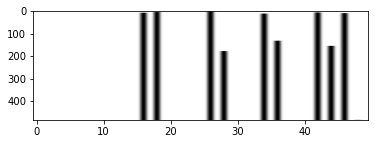

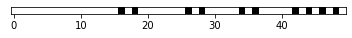

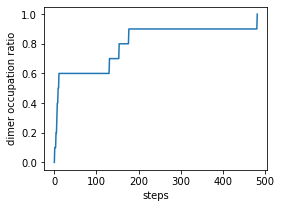

In [63]:
n = 5 # number of dimers
m = 50 # number of DNA binding sites
model = Model(dimers=n,dna_length=m,affinity='periodic')
#model.draw()
steps = 1000

draw_graph = False
G = model.G
length = model.length
exclusion_neighbours = 1
dbd_pairs = get_dbd_pairs(n)
affinity = nx.get_node_attributes(G,'affinity')


occupations = []
for idx in range(steps):
    G = link_dbd(G,length,affinity,dbd_pairs,exclusion_neighbours)
    occupation = check_dna_occupation(G,length)
    occupations.append(occupation)
    if np.sum(occupation) == (n*2):
        print(idx)
        break
        
print(np.sum(occupation),n*2)
if draw_graph:
    widths = nx.get_edge_attributes(G, 'weight')
    sizes = nx.get_node_attributes(G, 'size')
    nx.draw(G,width=list(widths.values()),node_size=2)

fig,ax=plt.subplots(figsize=[6,2])
ax.imshow(np.array(occupations),cmap='Greys',aspect='auto')

fig,ax=plt.subplots()
ax.imshow(np.array([occupation]),cmap='Greys')
ax.set_yticks([])

cum = np.sum(occupations,axis=1)
fig,ax=plt.subplots(figsize=[4,3])
ax.plot(cum/(n*2))
ax.set_xlabel('steps')
ax.set_ylabel('dimer occupation ratio')

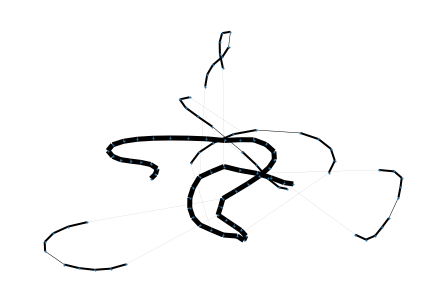

In [64]:
G = model.G
widths = nx.get_edge_attributes(G, 'weight')
sizes = nx.get_node_attributes(G, 'size')
nx.draw(G,width=list(widths.values()),node_size=1)

### Version 2:

In [67]:
class System:

    def __init__(self,dimers=1,dna_length=10,affinity='periodic',circular=False):
        
        self.monomers = 0
        self.n_dimers = dimers
        self.length = dna_length
        self.circular =  circular
        self.affinity_type = affinity
        
        # create a graph with n dimers and dna of length m
        self.G = self.initialize_graph()
        
        # assign binding affinity/probability to DNA sites/nodes
        self.affinity = self.get_DNA_affinity()
        
        # make dictionary of dbds that are connected in dimers
        self.dbd_pairs = self.get_dbd_pairs()

    def make_monomer(self,chain_id=0):
        
        G = nx.Graph()
        neigbour_list = {'dbd':['l2'],
                     'l2':['dbd','s2'],
                     's2':['h3','l2'],
                     'h3':['s2','s1'],
                     's1':['h3']}
        
        neigbour_list = {node+f'_{chain_id}':[n+f'_{chain_id}' for n in neigbors] for node,neigbors in neigbour_list.items()}
        for site in neigbour_list.keys():
            G = self.add_segment(G,site,chain_id,neigbour_list,verbose=False)
        return G
    
    def make_dimer(self):
        n_monomers = self.monomers
        a,b =  n_monomers,n_monomers+1
        G = self.make_monomer(chain_id=a)
        H = self.make_monomer(chain_id=b)
        F = nx.compose(G,H)
        F.add_edge(f's1_{a}',f's1_{b}',weight=0.5)
        self.monomers += 2
        return F
    
    def initialize_graph(self):
        dimers = [self.make_dimer() for idx in range(self.n_dimers)]
        G = nx.compose_all(dimers)
        return self.add_DNA(G,self.length,circular=self.circular,affinity=self.affinity_type)
    
    def get_DNA_affinity(self):
        return nx.get_node_attributes(self.G,'affinity')
    
    def get_dbd_pairs(self):
        k = np.split(np.arange(self.n_dimers*2),self.n_dimers)
        dbd_pairs_a = {f'dbd_{i}':f'dbd_{j}' for i,j in k}
        dbd_pairs_b = {f'dbd_{j}':f'dbd_{i}' for i,j in k}
        dbd_pairs = dbd_pairs_a | dbd_pairs_b
        return dbd_pairs   
    
    def check_if_potenial_neigbor(self,neigbors,node):
        try:
            a = neigbors.index(node)
            return a
        except ValueError:
            pass
    
    def add_segment(self,G,site,chain_id,neigbor_list,verbose=False):
        if verbose:
            print(f'try to add {site} to graph')
        n_nodes = len(G.nodes)
        if n_nodes == 0:
            if verbose:
                print(f'\tgraph is empty so {site} is added')
            G.add_node(site,size=int(5))
        else:
            if verbose:
                print(f'\tgraph is not empty so will search if {site} is allowed to be added')
            nodes = G.nodes
            neigbors = neigbor_list[site]
            neigbor_indices = [i for i in [self.check_if_potenial_neigbor(neigbors,node) for node in nodes] if i is not None] 
            if neigbor_indices:
                if verbose:
                    print(f'\t {site} has {len(neigbor_indices)} neigbours, so it is allowed to be added')
                for idx in neigbor_indices:
                    G.add_edge(site,neigbors[idx],weight=2)
            else:
                if verbose:
                    print(f'\t {site} cannot be added, since it has no potential neigbors')
        return G
    
    def make_periodic(self,idx):
        if (idx % 2) == 0:
            return 1
        else:
            return 0

    def add_DNA(self,G,length,circular=False,affinity='binary'):
        F = nx.Graph()
        sequence = np.arange(0,length)
        connections = [[i,i+1] for i in sequence][:sequence[-1]]
        if affinity == 'random':
            affinity = {idx:p for idx,p in enumerate(np.random.uniform(0,1,length))}
        elif affinity == 'binary':
            affinity  = {idx:p for idx,p in enumerate(np.random.randint(0,2,length))}
        elif affinity == 'periodic':
            affinity = {idx:self.make_periodic(idx) for idx in np.arange(length)}

        if circular:
            connections.append([0,sequence[-1]])
        F.add_nodes_from(sequence,size=10)
        F.add_edges_from(connections,weight=5)
        nx.set_node_attributes(F,affinity,"affinity")
     
        return nx.compose(G,F)
    
    def draw(self):
        widths = nx.get_edge_attributes(self.G, 'weight')
        sizes = nx.get_node_attributes(self.G, 'size')
        nx.draw(self.G,width=list(widths.values()),node_size=2)

In [446]:
class Model(System):
    
    def get_random_dbd(self):
        dbds = np.array([node for node in self.G.nodes if 'dbd' in str(node) ])
        return np.random.choice(dbds)
    
    def get_random_dna(self):
        return np.random.randint(0,self.length)
    
    def check_bound_state_dbd(self,dbd_node):
        # returns list with dna binding site
        # find neigbours of random dbd
        dbd_neigbours = list(self.G.neighbors(dbd_node))
            
        # Check if selected dbd is not already bound to dna        
        return [n for n in dbd_neigbours if type(n) == int]
    
    def check_bound_state_dna(self,dna_node):
         # returns true if dna binding site is occupied
        if [i for i in self.G.neighbors(dna_node) if 'dbd' in str(i)]:
            return 1
        else:
            return 0 
        
    def check_dna_occupation(self):
        dna_nodes = np.arange(0,self.length)
        return [check_if_bound(self.G,n) for n in dna_nodes]

    def check_if_neighbors(self,a,b):
        return a in self.G.neighbors(b)
     
    def evalutate_unbinding(self,dna_node,dbd_node):
        
        unbinding_probability = 0.25
        break_link = np.random.binomial(1,unbinding_probability)
        if break_link:
            self.G.remove_edge(dna_node,dbd_node)
    
    def check_dbd_bound_state(self,dbd_node):
    
        # find neigbours of dbd
        dbd_neigbours = list(self.G.neighbors(dbd_node))
        
         # Check if selected dbd is not already bound to dna        
        return [n for n in dbd_neigbours if type(n) == int]
    
    def check_dna_bound_state(self,dna_node):
        
        # find neigbours of dna
        dna_neigbours = list(self.G.neighbors(dna_node))
        
        # If a dbd is among neighbors (assumes only one dbd can be bound)
        check = [n for n in dna_neigbours if 'dbd' in str(n)]
        
        if check:
            return 1
        else:
            return 0
        
    def get_nearest_dna_neighbors(self,dna_node,n=1):
        # ego graph returns induced subgraph of neighbors centered at node n within a given radius
        n = nx.ego_graph(self.G,dna_node,radius=n)
        # returns only neighboring dna nodes (not the dna node itself and dbd)
        return [n for n in n.nodes if n != dna_node and 'dbd' not in str(n)]
        
    
    def get_dbd_pair_state(self,dbd_node):
        
        # get secondary dbd of dimer
        dbd_pair = self.dbd_pairs[dbd_node]

        # Check if selected dbd is not already bound to dna  
        dbd_pair_dna_site = self.check_dbd_bound_state(dbd_pair)
        
        if not dbd_pair_dna_site:
            return None
        else:
            return dbd_pair_dna_site[0]
        
    def evaluate_binding(self, dna_node,dbd_node):
    
    
        dbd_affinity = np.random.binomial(1,0.5)
        dna_affinity = self.affinity[dna_node]
        binding_probability = dbd_affinity * dna_affinity
        make_link = np.random.binomial(1,binding_probability)

        if make_link:

            self.G.add_edge(dna_node,dbd_node,weight=0.05)

        
    def update(self):
        
        # pick random DNA and DBD node
        dbd_node = self.get_random_dbd()
        dna_node = self.get_random_dna() # or select random window at DNA sequence and then evalute affinity
         
        # check if random selected nodes are already bound
        if  self.check_if_neighbors(dbd_node,dna_node):
            # if yes, evaluate probabilty that pair unbinds
            self.evalutate_unbinding(dna_node,dbd_node)
            
        else:
            # check if dbd_node is not already bound to more than one edge 
            # if more than one, means dbd is already bound to dna
            dbd_bound_state = (len(self.G.edges(dbd_node)) != 1)
            
            # check if dna_node is already bound to a dbd node
            dna_bound_state = (self.check_dna_bound_state(dna_node))
            
            # if both dbd_node and dna_node are not already bound
            if not dbd_bound_state and not dna_bound_state:
                    
                # check occupancy of DNA n neighbors
                dna_sites = self.get_nearest_dna_neighbors(dna_node,n=1)
                # returns 1 if bound and 0 if not bound
                dna_site_states = [self.check_dna_bound_state(site) for site in dna_sites]    
                
                # check if secondary dbd is already bound (returns None if unbound)
                dbd_pair_state = self.get_dbd_pair_state()
            
                # no neighboring dna sites, and no secondary dbd is bound
                    # proceed with evalutation of binding

                # no neigboring dna sites, and secondary dbd is bound
                    # check where secondary dbd is bound
                        # if too far away from dna node, reject
                        # else evalute binding 

                # occupied neighboring dna sites, and secondary dbd is unbound
                    # 
                # occupied neighboring dna sites, and no secondary dbd is bound
                    #
                    
                # if sum is zero dna nodes 1 neighbor away contain no dbd
                if sum(dna_site_states) == 0 and dbd_pair_state == None:
                    self.evaluate_binding(dbd_node,dna_node)
                    
                else:
                    

                    
                    
                    
                    # no neighboring dna sites can be occupied
                        # but the secondary dbd might already be bound
                    

#                     # get secondary dbd of dimer
#                     dbd_pair = self.dbd_pairs[dbd_node]

#                     # Check if selected dbd is not already bound to dna  
#                     dbd_pair_dna_site = self.check_dbd_bound_state(dbd_pair)
                   
#                     # if paired dbd is not bound, evaluate binding
#                     if not dbd_pair_dna_site: 
                            
#                             self.G.add_edge(dna_node,dbd_node,weight=0.05)   
                    
#                     # if paired dbd is bound, checkpair dbd in not further away bound than 1 site
#                     elif np.abs(dbd_pair_dna_site[0] - dna_node) < 3:
#                         #print(dbd_pair_dna_site, dna_node)
#                         self.G.add_edge(dna_node,dbd_node,weight=0.05) 
                        
                    #if dbd_pair_dna_site:
                    #    site_seperation = np.abs(dbd_pair_dna_site[0] - dna_node)
                    #else:
                    #    site_seperation = 0
                    #    
                    #if  site_seperation < 2:
                    #    #print(bound_dbd_pair,dna_sites)

                           
                

        
#                 # Check occupancy of DNA n neighbors
#                 dna_sites = self.get_nearest_dna_neighbors(dna_node,n=1)
#                 dna_site_states = [self.check_dna_bound_state(site) for site in dna_sites]

#                 occupied = ['dbd' in str(item) for item in dna_site_states]
#                 #print(occupied)
#                 #print(dbd_bound_state, bound, occupied)
                
#                 # if dna neighbors are already occupied, reject, else continue
#                 if not occupied:

#                     # Check if secondary DBD is in neighbors
#                     dbd_pair = self.dbd_pairs[dbd_node]

#                     # Check if selected dbd is not already bound to dna  
#                     bound_dbd_pair = self.check_dbd_bound_state(dbd_pair)

#                     if not any(bound_dbd_pair):

#                         dbd_affinity = np.random.binomial(1,0.5)
#                         dna_affinity = self.affinity[dna_node]
#                         binding_probability = dbd_affinity * dna_affinity
#                         make_link = np.random.binomial(1,binding_probability)

#                         if make_link:
#                             self.G.add_edge(dna_node,dbd_node,weight=0.05)

# dna node
# dbd node

# check if dbd is bound 
    # if not continue
    # else evalute undbinding

# check dna neighbours
    # if neighbors occupied, reject
    # else continue

# 

In [452]:
ns = 1
ps = ns*1e3

dt = 0.002 # in picoseconds 
steps = (ns*1e3)/dt
steps

500000.0

In [459]:
(50000*0.002) / 1000

0.1

[6] 4
[4] 6
[9] 11
[11] 9
[11] 9
[4] 2
[9] 11
[9] 11
[4] 2
[7] 9
[2] 4
[7] 9
[2] 4
[9] 7
[4] 2
[2] 0
[7] 9
[7] 9
[2] 0
[9] 7
[0] 2
[7] 5
[0] 2
[0] 2
[5] 7
[5] 7
[5] 3
[11] 13
[5] 3
[13] 11
[5] 3
[5] 7
[11] 9
[5] 7
[0] 2
[3] 5
[9] 7
[5] 3
[9] 7
[5] 3
[9] 11
[5] 7
[9] 11
[0] 2
[9] 11
[11] 13
[2] 4
[13] 11
[4] 6
[11] 9
[11] 9
[6] 4
[2] 0
[8] 6
[4] 2
[2] 4
[8] 6
[2] 4
[6] 8
[8] 10
[2] 4
[8] 10
[2] 0
[8] 6
[6] 8
[6] 4
[4] 6
[0] 2
[2] 0
[6] 8
[6] 8
[8] 10
[0] 2
[6] 4
[8] 10
[4] 6
[4] 6
[8] 10
[10] 12
[4] 6
[12] 14
[9] 7
[12] 14
[12] 14
[9] 7
[9] 11
[7] 9
[11] 9
[9] 7
[7] 9
[13] 11
[13] 11
[9] 7
[11] 13
[7] 5
[5] 3
[5] 7
[7] 5
[2] 4
[7] 9
[2] 0
[2] 4
[2] 4
[7] 9
[9] 7
[2] 4
[4] 2
[2] 4
[12] 14
[2] 4
[4] 2
[2] 0
[14] 12
[12] 10
[10] 12
[10] 12


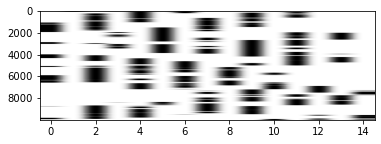

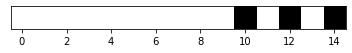

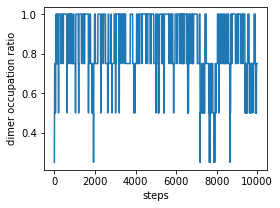

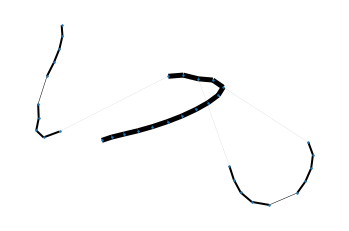

In [447]:
n = 2 # number of dimers
m = 15 # number of DNA binding sites
model = Model(dimers=n,dna_length=m,affinity='periodic',circular=False)
#model.draw()
steps = 10000

# draw_graph = False
# G = model.G
# length = model.length
# exclusion_neighbours = 1
# dbd_pairs = get_dbd_pairs(n)
# affinity = nx.get_node_attributes(G,'affinity')


occupations = []
for idx in range(steps):
    model.update()
    
    occupation = check_dna_occupation(model.G,model.length)
    occupations.append(occupation)
    
fig,ax=plt.subplots(figsize=[6,2])
ax.imshow(np.array(occupations),cmap='Greys',aspect='auto')

fig,ax=plt.subplots()
ax.imshow(np.array([occupation]),cmap='Greys')
ax.set_yticks([])

cum = np.sum(occupations,axis=1)
fig,ax=plt.subplots(figsize=[4,3])
ax.plot(cum/(n*2))
ax.set_xlabel('steps')
ax.set_ylabel('dimer occupation ratio')

fig,ax=plt.subplots()
model.draw()

In [438]:
dbd_nodes = [node for node in model.G.nodes if 'dbd' in str(node)]
dbd_node_neighbors = [ [node,list(model.G.neighbors(node))] for node in dbd_nodes]
dbd_node_neighbors

[['dbd_0', ['l2_0']],
 ['dbd_1', ['l2_1', 14]],
 ['dbd_2', ['l2_2']],
 ['dbd_3', ['l2_3', 4]]]

In [439]:
for node in range(model.length):
    print([node, list(model.G.neighbors(node))])

[0, [1]]
[1, [0, 2]]
[2, [1, 3]]
[3, [2, 4]]
[4, [3, 5, 'dbd_3']]
[5, [4, 6]]
[6, [5, 7]]
[7, [6, 8]]
[8, [7, 9]]
[9, [8, 10]]
[10, [9, 11]]
[11, [10, 12]]
[12, [11, 13]]
[13, [12, 14]]
[14, [13, 'dbd_1']]


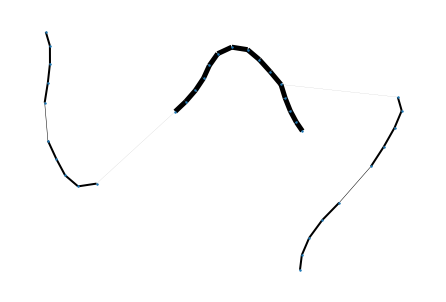

In [440]:
model.draw()

In [258]:
list(model.G.neighbors('dbd_2'))

['l2_2', 4]

[1]
[0, 2]
[1, 3]
[2, 4, 'dbd_0']
[3, 5, 'dbd_2']
[4, 6]
[5, 7]
[6, 8]
[7, 9]
[8, 10]
[9, 11]
[10, 12]
[11, 13]
[12, 14]
[13, 15]
[14, 16]
[15, 17]
[16, 18]
[17, 19]
[18, 20]
[19, 21]
[20, 22]
[21, 23]
[22, 24]
[23, 25]
[24, 26]
[25, 27]
[26, 28]
[27, 29]
[28, 30]
[29, 31]
[30, 32]
[31, 33]
[32, 34]
[33, 35]
[34, 36, 'dbd_8']
[35, 37]
[36, 38]
[37, 39]
[38, 40]
[39, 41]
[40, 42]
[41, 43]
[42, 44]
[43, 45]
[44, 46]
[45, 47]
[46, 48]
[47, 49]
[48, 50, 'dbd_7']


In [ ]:
#         if bound_dbd_pair:
#             pass
#             # Evaluate neighbor distance

#         else:
#             pass
                
                
#         dbd_affinity = np.random.binomial(1,0.5)
        
       
#         dna_affinity = self.affinity[dna_node]
#         occupation = self.check_bound_state_dna(dna_node)
        
    
#         if not occupation:
            
#             binding_probability = dbd_affinity * dna_affinity
#             make_link = np.random.binomial(1,binding_probability)
            
#             if make_link:
#                 self.G.add_edge(dna_node,dbd_node,weight=0.05)
                
#         elif dna_node in self.G.neighbors(dbd_node):
    
#             unbinding_probability = 0.25
#             break_link = np.random.binomial(1,unbinding_probability)
            
#             if break_link:
#                 self.G.remove_edge(dna_node,dbd_node)
                

            
        
        
#         dbd_node = self.get_random_dbd()
#         dna_node = self.get_random_dna()
        
#         # returns list with dna binding site
#         self.check_bound_state_dbd(dbd_node)
        
#          # returns true if dna binding site is occupied
#         self.check_bound_state_dna(dna_node)
        
#         # returns for each dna binding site if its bound to dbd or not
#         self.check_dna_occupation()
        
        
        
#         # pick random dna node
#         dna_node  = self.get_random_dna()
#         # get affinity of dna node (this code assumes binary affinities)
#         binding_site_affinity = self.affinity[dna_node]
        
#         # check if dna is a binding site
#         if binding_site_affinity:
            

    
# def link_dbd(G,length,affinity,dbd_pairs,exclusion_neighbours=1):

#     # pick random dna node
#     dna_node  = get_random_dna(length)
#     # get affinity of dna node
#     binding_site = affinity[dna_node]

#     # check if dna is a binding site
#     if binding_site:
 
#         # find dna neigbors
#         dna_neigbours = list(G.neighbors(dna_node))
        
#         # Check if dna binding site is not already bound to a dbd
#         bound_dna = [n for n in dna_neigbours if 'dbd' in str(n)]
        
#         if not bound_dna:
            
#             # Pick random dbd
#             dbd_node = get_random_dbd(G)
            
#             # Check if selected dbd is not already bound to dna    
#             bound_dbd = check_dbd_bound_state(G,dbd_node,length)
            
#             if not bound_dbd:
                
#                 # find dbd secondary site
#                 dbd_pair = dbd_pairs[dbd_node]
                
#                 # Check if selected dbd is not already bound to dna    
#                 bound_dbd_pair = check_dbd_bound_state(G,dbd_pair,length)
                
#                 if not bound_dbd_pair:
                
#                     # add edge to dbd and dna
#                     G.add_edge(dbd_node,dna_node,weight=0.05)
#                     #print('yes',dbd_node,dna_node)
                    
#                 elif bound_dbd_pair:
                    
#                     # check if distance of second spot is far enough (also check if at next neighbor is also not already dbd)
#                     dist = np.abs(bound_dbd_pair[0]-dna_node)
                    
#                     if 2 <= dist < 3:
#                         # add edge to dbd and dna
#                         G.add_edge(dbd_node,dna_node,weight=0.05)
#                         #print('yes',dbd_node,dna_node)
                        
#     return G

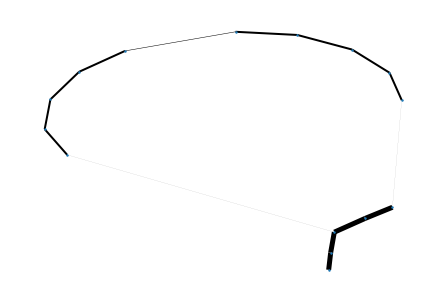

In [80]:
model.draw()

Text(0, 0.5, 'dimer occupation ratio')

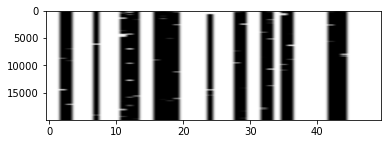

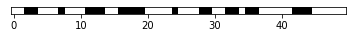

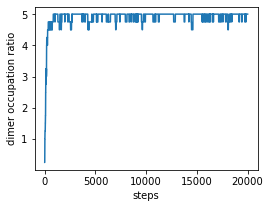

In [54]:
n = 2 # number of dimers
m = 50 # number of DNA binding sites
model = Model(dimers=n,dna_length=m,affinity='binary')
#model.draw()
steps = 20000

# draw_graph = False
# G = model.G
# length = model.length
# exclusion_neighbours = 1
# dbd_pairs = get_dbd_pairs(n)
# affinity = nx.get_node_attributes(G,'affinity')


occupations = []
for idx in range(steps):
    model.update()
    # G = link_dbd(G,length,affinity,dbd_pairs,exclusion_neighbours)
    occupation = check_dna_occupation(model.G,model.length)
    occupations.append(occupation)
    # if np.sum(occupation) == (n*2):
    #     print(idx)
    #     break
    
if draw_graph:
    widths = nx.get_edge_attributes(G, 'weight')
    sizes = nx.get_node_attributes(G, 'size')
    nx.draw(G,width=list(widths.values()),node_size=2)

fig,ax=plt.subplots(figsize=[6,2])
ax.imshow(np.array(occupations),cmap='Greys',aspect='auto')

fig,ax=plt.subplots()
ax.imshow(np.array([occupation]),cmap='Greys')
ax.set_yticks([])

cum = np.sum(occupations,axis=1)
fig,ax=plt.subplots(figsize=[4,3])
ax.plot(cum/(n*2))
ax.set_xlabel('steps')
ax.set_ylabel('dimer occupation ratio')

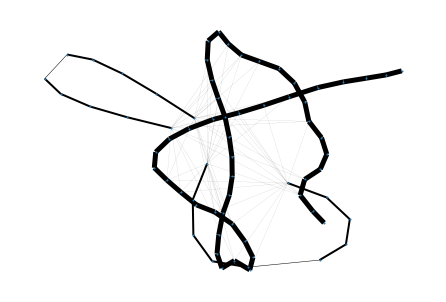

In [55]:
G = model.G
widths = nx.get_edge_attributes(G, 'weight')
sizes = nx.get_node_attributes(G, 'size')
nx.draw(G,width=list(widths.values()),node_size=1)

In [56]:
G

In [ ]:
# update
    
    # choose random dna node (each dna node has an affinity probability)
        # look at occupations of neighbouring dna nodes  
    
    # check if dna node is already bound to dbd
       
        # if yes, the dna node is occupied
        
            # evaluate if dissociation/link-breakage occurs
        
        
        # if no, the dna node is unoccupied
           
            # pick random dbd 
                
            # check if dbd is bound to another dna node
                
                
                # if yes, dbd is already bound
                    
                    # reject dbd node
                
                # if no, dbd is not already bound
                    
                    # check if direct/secondary dbd is already bound
                    
                    # if yes, secondary dbd is bound
                    
                        # check if dna nodes are not too far from each other
                    
                        # if  dna nodes are too far
                            # reject dbd node
                        
                        # if not to far
                            
                            # continue to direct neighbor check
                    
                    
                    # if no, check if neighboring dna nodes are occupied (how far?)
                    
            
                        # if yes, evalute probability of dimer link? and evaluate dna node link?
                
                        # if no, add evaluate link between dbd node and dna node
        
    

In [ ]:
# update
    
    # pick random dbd (later evaluate probabilty of conformational state)
    
    # check if dbd is bound to a dna node
    
        # if yes, dbd is already bound
        
            # evaluate dissociation probability
                
            # should this probability be affected by whether there is a dimer link?
            
        # if no, dbd is not already bound
        
            # check if direct/secondary dbd is already bound
                
                # if yes, secondary dbd is bound
                
                    # pick random dna node from selection based on action radius of dimer/affected by yes/no dimer linkage? 
                
                    # check if dna nodes are not too far from each other
                    
                    # evalutate binding probabilty of dbd node 
                    
                
                # if no, secondary dbd is not bound
                
                    # pick random dna node 
                        
                        # check if dna node is already occupied
                        
                            # if dna node is unoccupied
                            
                                # check neigbouring dna nodes for occupation
                            
                                    # if direct neigbour is occupied
                                        
                                        # reject dbd node
                                    
                                    # if second (make variable) nearest neigbour is occupied
                                    
                                        # evaluate binding probabilty for linkage/binding
                                        
                                        # evaluate dimer dimer linkage?
                                        
                                        # or reverse order?
                                
                            # if dna node is occupied
                            
                                # reject dbd node 
                                
                        
                    
                        
    
    

        
    

In [21]:
n_dimers = 100
length = 250
exclusion_neighbours = 1
dbd_pairs = get_dbd_pairs(n_dimers)
draw_graph = False
# each step
    # pick random dimer
    # pick random binding site
    # check affinity
    # check vicinity (exclusion neigbours)
    
# initialize system
N_MONOMERS = 0 # Global counter of monomers

dimers = [make_dimer(N_MONOMERS) for idx in range(n_dimers)]
G = nx.compose_all(dimers)

# widths = nx.get_edge_attributes(G,'weight')
# sizes = nx.get_node_attributes(G,'size')

# even = np.arange(0,n*2,2)
# odd = np.arange(2,n*2,2)
# for i,j in zip(even,odd):
#     link_dimer(G,i,j)
    
G = add_DNA(G,length,circular=False,affinity='binary')
affinity = nx.get_node_attributes(G,'affinity')

occupations = []
for idx in range(50000):
    G = link_dbd(G,length,affinity,dbd_pairs,exclusion_neighbours)
    occupation = check_dna_occupation(G,length)
    occupations.append(occupation)
    if np.sum(occupation) == (n_dimers*2):
        print(idx)
        break
        
print(np.sum(occupation),n_dimers*2)
if draw_graph:
    widths = nx.get_edge_attributes(G, 'weight')
    sizes = nx.get_node_attributes(G, 'size')
    nx.draw(G,width=list(widths.values()),node_size=2)

fig,ax=plt.subplots(figsize=[6,2])
ax.imshow(np.array(occupations),cmap='Greys',aspect='auto')

fig,ax=plt.subplots()
ax.imshow(np.array([occupation]),cmap='Greys')
ax.set_yticks([])

cum = np.sum(occupations,axis=1)
fig,ax=plt.subplots(figsize=[4,3])
ax.plot(cum/(n_dimers*2))
ax.set_xlabel('steps')
ax.set_ylabel('dimer occupation ratio')

NameError: name 'make_dimer' is not defined

[]

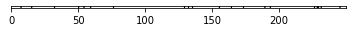

In [673]:
fig,ax=plt.subplots()
ax.imshow(np.array([list(affinity.values())]-np.array([occupation])),cmap='Greys')
ax.set_yticks([])

Text(0.5, 0, 'dna site index')

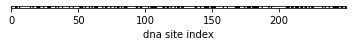

In [674]:
fig,ax=plt.subplots()
ax.imshow(np.array([occupation]),cmap='Greys')
ax.set_yticks([])
ax.set_xlabel('dna site index')

<AxesSubplot:ylabel='Density'>

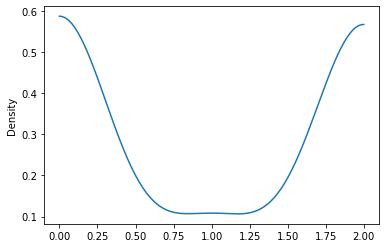

In [683]:
#plt.scatter(np.arange(length),np.array(list(affinity.values())+np.array(occupation)))
import seaborn as sns
sns.kdeplot(np.array(list(affinity.values())+np.array(occupation)),cut=0)

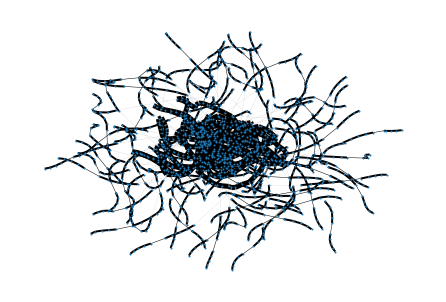

In [586]:
widths = nx.get_edge_attributes(G, 'weight')
sizes = nx.get_node_attributes(G, 'size')
nx.draw(G,width=list(widths.values()),node_size=1)

In [ ]:
population balance / reaction network model / 

# add proximity factor that links dimers
# add also dissociation of dbd

In [531]:
occupation
affinity.values()

dict_values([1, 0, 1, 0, 0, 0, 1, 0, 0, 1])

([], [])

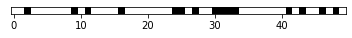

In [502]:
def check_if_bound(G,dna_node):
    if [i for i in G.neighbors(dna_node) if 'dbd' in str(i)]:
        return 1
    else:
        return 0 

def check_dna_occupation(G,length):
    dna_nodes = np.arange(0,length)
    return [check_if_bound(G,n) for n in dna_nodes]

occupation = check_dna_occupation(G,length)
#plt.bar(np.arange(len(occupation)),occupation)
plt.imshow(np.array([occupation]),cmap='Greys')
plt.yticks([])

In [379]:
plt.axis??

Signature: plt.axis(*args, emit=True, **kwargs)
Docstring:
Convenience method to get or set some axis properties.

Call signatures::

  xmin, xmax, ymin, ymax = axis()
  xmin, xmax, ymin, ymax = axis([xmin, xmax, ymin, ymax])
  xmin, xmax, ymin, ymax = axis(option)
  xmin, xmax, ymin, ymax = axis(**kwargs)

Parameters
----------
xmin, xmax, ymin, ymax : float, optional
    The axis limits to be set.  This can also be achieved using ::

        ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax))

option : bool or str
    If a bool, turns axis lines and labels on or off. If a string,
    possible values are:

    ======== ==========================================================
    Value    Description
    ======== ==========================================================
    'on'     Turn on axis lines and labels. Same as ``True``.
    'off'    Turn off axis lines and labels. Same as ``False``.
    'equal'  Set equal scaling (i.e., make circles circular) by
             changing axis limits

In [74]:
np.random.randint(0,length)

2

try to add dbd to graph
	graph is empty so dbd is added
try to add l2 to graph
	graph is not empty so will search if l2 is allowed to be added
	 l2 has 1 neigbours, so it is allowed to be added
try to add h3 to graph
	graph is not empty so will search if h3 is allowed to be added
	 h3 cannot be added, since it has no potential neigbors
try to add s2 to graph
	graph is not empty so will search if s2 is allowed to be added
	 s2 has 1 neigbours, so it is allowed to be added


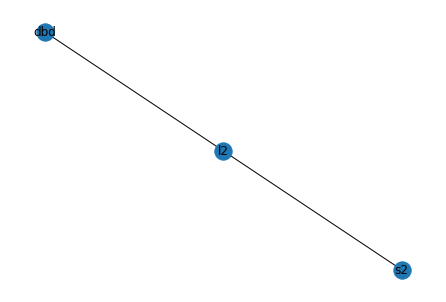

In [12]:
neigbor_list = {'dbd':['l2'],
             'l2':['dbd','s2'],
             's2':['h3','l2'],
             'h3':['s2','s1'],
             's1':['h3']}
verbose = True
G = nx.Graph()
G = add_segment(G,site='dbd',chain_id=0,neigbor_list=neigbor_list,verbose=verbose)
G = add_segment(G,site='l2',chain_id=0,neigbor_list=neigbor_list,verbose=verbose)
G = add_segment(G,site='h3',chain_id=0,neigbor_list=neigbor_list,verbose=verbose)
G = add_segment(G,site='s2',chain_id=0,neigbor_list=neigbor_list,verbose=verbose)
nx.draw(G,with_labels=True)

In [189]:
G = nx.Graph()


l = 100
n = 200

if n%2 != 0:
    n+=1
    
even = np.arange(0,n*2,2)
odd = np.arange(1,n*2,2)
for i,j in zip(even,odd):
    add_dimer(G,i,j)

# link_s2(G,0,4)

# add_DNA(G,600,circular=True)

a = np.random.choice(even,replace=False,size=l)
b = np.random.choice(odd,replace=False,size=l)
linked = np.array([a,b]).T
for i,j in linked:
    link_s2(G,i,j)

len(nx.cycle_basis(G))
# widths = nx.get_edge_attributes(G, 'weight')
# sizes = nx.get_node_attributes(G, 'size')
# nx.draw(G,width=list(widths.values()),node_size = list(sizes.values()))


2

In [191]:
len(nx.cycle_basis(G))
nx.cycle_basis(G)[1]

['332_s2',
 '283_s2',
 '283_s1',
 '282_s1',
 '282_s2',
 '333_s2',
 '333_s1',
 '332_s1']

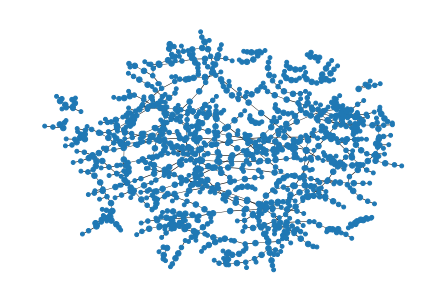

In [193]:
widths = nx.get_edge_attributes(G, 'weight')
sizes = nx.get_node_attributes(G, 'size')
nx.draw(G,width=list(widths.values()),node_size = list(sizes.values()))


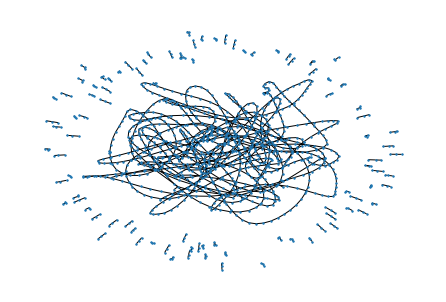

In [51]:
add_DNA(G,1000,circular=False)

for i in range(0,100):
    add_HNS(G,i)
    
nx.draw(G,node_size=2)